# N-BEATS Neural Basis expansion analysis for interpretable time series forecasting 

The main goal of this notebook is show some of the theory about N-BEATS and an application with some macroeconomic data.

In [2]:
import torch as t
import numpy as np
import pandas as pd
from hyperopt import hp
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'hyperopt'

In [2]:
import neuralforecast as nf

In [6]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt


In [4]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [10]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NBEATS(h=12, input_size=24,
               loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_steps=100,
               val_check_steps=10,
               early_stop_patience_steps=2,
               activation = 'ReLU')

fcst = NeuralForecast(
    models=[model],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.42it/s]


[]

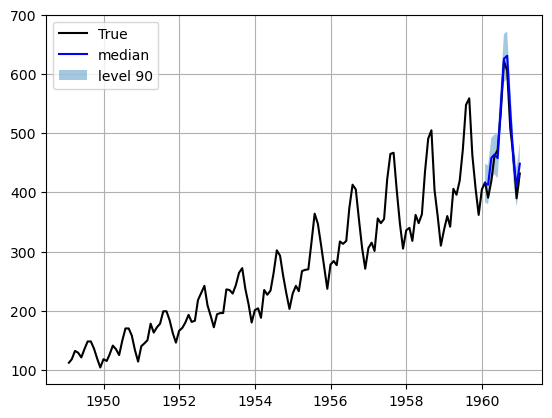

In [11]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['NBEATS-lo-90'][-12:].values, 
                 y2=plot_df['NBEATS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()

Global seed set to 1
Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.30it/s]


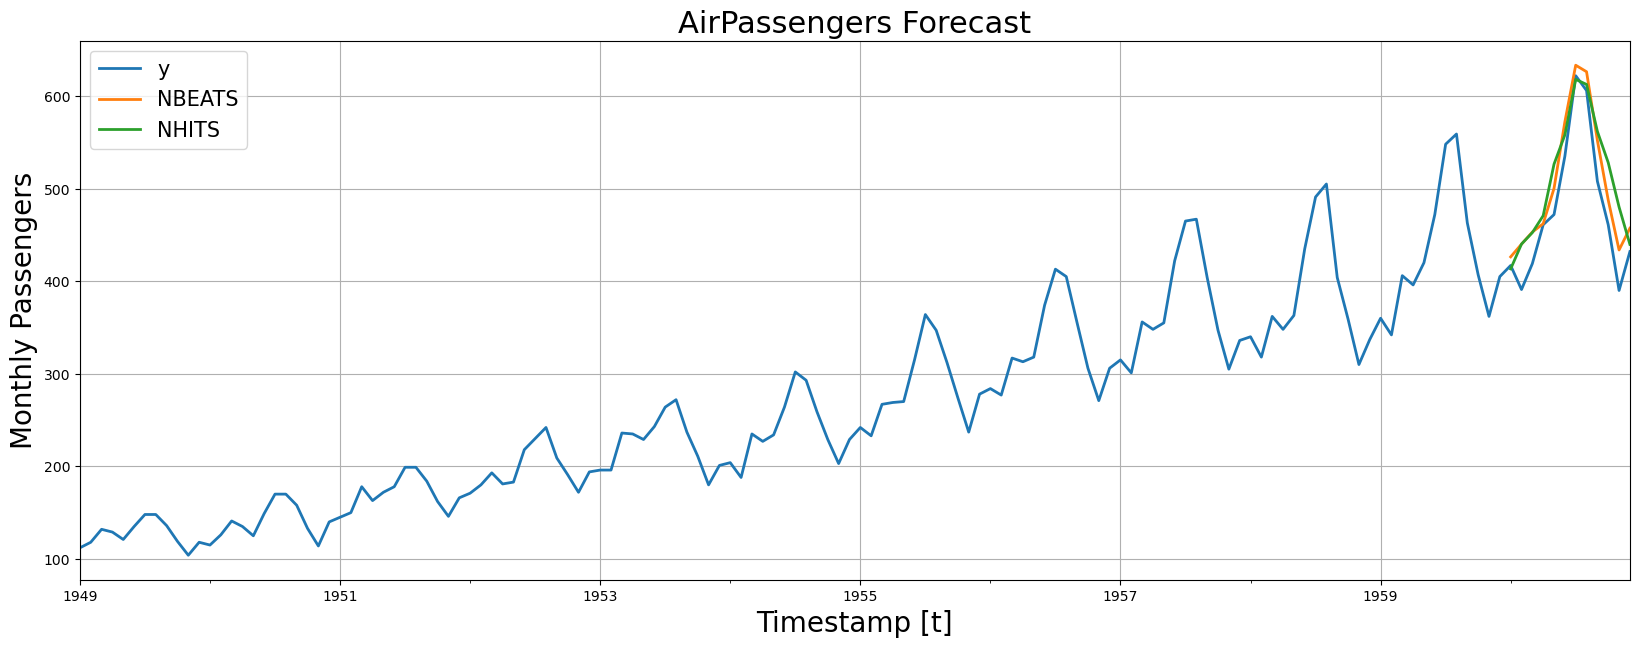

In [8]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF

# Split data and declare panel dataset
Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
          NHITS(input_size=2 * horizon, h=horizon, max_steps=50)]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()